Assignment 05 Yaofa Gong 306299097

This assignment is a cleanup and improvement of the midterm assignment code. I will be rewriting some of the processes in the previous code using loops and functions as a way to make the code more logical and easier to run.

# Import Python libraries

In [24]:
import pandas as pd
import geopandas as gpd
import os
import folium 
import matplotlib.pyplot as plt
from sodapy import Socrata
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import numpy as np

# Import data 
The initial goal of this experiment was to look at the relationship between the distribution of traffic accidents and different age distributions based on preliminary visualization data. So I was initially going to try to observe the data all on the same map.

In [25]:
LA_AGE_DISTRIBUTION = pd.read_csv('LA_AGE_DISTRIBUTION_adjust.csv')
results_incidents_1 = pd.read_csv('Major_Safety_Events_20240206.csv', low_memory=False)
results_incidents_2 = pd.read_csv('Traffic_Collision_Data_from_2018to2022.csv', low_memory=False)

# Adjustment of data

In [26]:
# Add 'geometry' element to age distribution data.
la_geo_data = gpd.GeoDataFrame(LA_AGE_DISTRIBUTION, geometry=gpd.GeoSeries.from_wkt(LA_AGE_DISTRIBUTION['geometry']))

# Convert incident data to pandas DataFrame
public_incident = pd.DataFrame.from_records(results_incidents_1)
private_incident = pd.DataFrame.from_records(results_incidents_2)

# Conversion of incident data into geographic data
public_incident['geometry'] = public_incident.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
public_accident = gpd.GeoDataFrame(public_incident, geometry='geometry')


/tmp/ipykernel_230/3139464937.py:5: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  public_incident = pd.DataFrame.from_records(results_incidents_1)
/tmp/ipykernel_230/3139464937.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  private_incident = pd.DataFrame.from_records(results_incidents_2)


# Define a function that handles private accident data.

In [27]:
def parse_location(location_str):
    try:
        lat, lon = map(float, location_str.strip("()").split(", "))
        return Point(lon, lat)
    except:
        return None

# apply the function and sdjust private accident data.

In [28]:
# Apply the function
private_incident['geometry'] = private_incident['Location'].apply(parse_location)

# Remove unneeded lines
private_accident = private_incident.dropna(subset=['geometry'])

# Conversion of incident data into geographic data
private_accident = gpd.GeoDataFrame(private_incident, geometry='geometry')

# Set up and harmonize coordinate systems.

In [29]:
la_geo_data.set_crs(epsg=4326, inplace=True)
public_accident.set_crs(epsg=4326, inplace=True)
private_accident.set_crs(epsg=4326, inplace=True)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location,geometry
0,180104039,01/01/2018,01/01/2018,1740,1,Central,192,997,TRAFFIC COLLISION,3101 3401 3701 3009 3025 3036,50.0,F,O,101.0,STREET,VENICE BL,GRAND AV,"(34.0363, -118.2677)",POINT (-118.26770 34.03630)
1,180104668,01/10/2018,01/01/2018,1540,1,Central,182,997,TRAFFIC COLLISION,3101 3401 3701 3004 3030,NaN,M,W,101.0,STREET,VERDUGO RD,YUKON,"(34.042, -118.2625)",POINT (-118.26250 34.04200)
2,180104040,01/01/2018,01/01/2018,1900,1,Central,154,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030 3032,25.0,M,W,108.0,PARKING LOT,SPRING,6TH,"(34.046, -118.2509)",POINT (-118.25090 34.04600)
3,180104001,01/01/2018,01/01/2018,38,1,Central,192,997,TRAFFIC COLLISION,3101 3401 3701 3002 3011 3034 3036,NaN,M,H,101.0,STREET,GRAND,WASHINGTON,"(34.0327, -118.2683)",POINT (-118.26830 34.03270)
4,180104044,01/01/2018,01/01/2018,1030,1,Central,182,997,TRAFFIC COLLISION,3101 3401 3701 3004 3026 3036,33.0,M,B,101.0,STREET,HOPE,PICO,"(34.0395, -118.2656)",POINT (-118.26560 34.03950)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175003,220604002,01/06/2022,01/01/2022,213,6,Hollywood,632,997,TRAFFIC COLLISION,3011 4006 3028 3035 3036 3101 3701 3401,99.0,NaN,NaN,101.0,STREET,STANLEY HILLS DR,LOOKOUT MOUNTAIN AV,"(34.1143, -118.3749)",POINT (-118.37490 34.11430)
175004,222004032,01/01/2022,01/01/2022,1330,20,Olympic,2074,997,TRAFFIC COLLISION,4027 3006 3026 3038 3035 3101 3401 3701 3037,54.0,M,H,101.0,STREET,VENICE BL,NORMANDIE AV,"(34.0437, -118.301)",POINT (-118.30100 34.04370)
175005,221004024,01/01/2022,01/01/2022,2145,10,West Valley,1049,997,TRAFFIC COLLISION,3011 3024 4026 3037 3039 3602 3101 3034,29.0,M,H,101.0,STREET,WOODLEY AV,BURBANK BL,"(34.1717, -118.4758)",POINT (-118.47580 34.17170)
175006,221404003,01/01/2022,01/01/2022,115,14,Pacific,1488,997,TRAFFIC COLLISION,4027 3035 3036 3101 3401 3701 3003 3024,46.0,M,W,101.0,STREET,96TH,AIRPORT BL,"(33.9494, -118.3859)",POINT (-118.38590 33.94940)


# Find all accident points that are in the region.

In [11]:
public_accidents_within_bounds = public_accident[public_accident.geometry.within(la_geo_data.unary_union)]
private_accidents_within_bounds = private_accident[private_accident.geometry.within(la_geo_data.unary_union)]

# Calculate the accident boundary points.

In [30]:
minx, miny, maxx, maxy = public_accidents_within_bounds.total_bounds
print([minx, miny, maxx, maxy])

minx, miny, maxx, maxy = private_accidents_within_bounds.total_bounds
print([minx, miny, maxx, maxy])

[-118.796754, 33.72697, -117.719291, 34.776]
[-118.6663, 33.7065, -118.1554, 34.3343]


# Define some parameters

In [31]:
# Defining Boundaries
public_accidents_bounds = [-118.796754, 33.72697, -117.719291, 34.776]
private_accidents_bounds = [-118.6663, 33.7065, -118.1554, 34.3343]

# Define name
people_list = ['youngster', 'middle-aged', 'elderly']

# Using loops to draw diagrams

<Figure size 3000x3000 with 0 Axes>

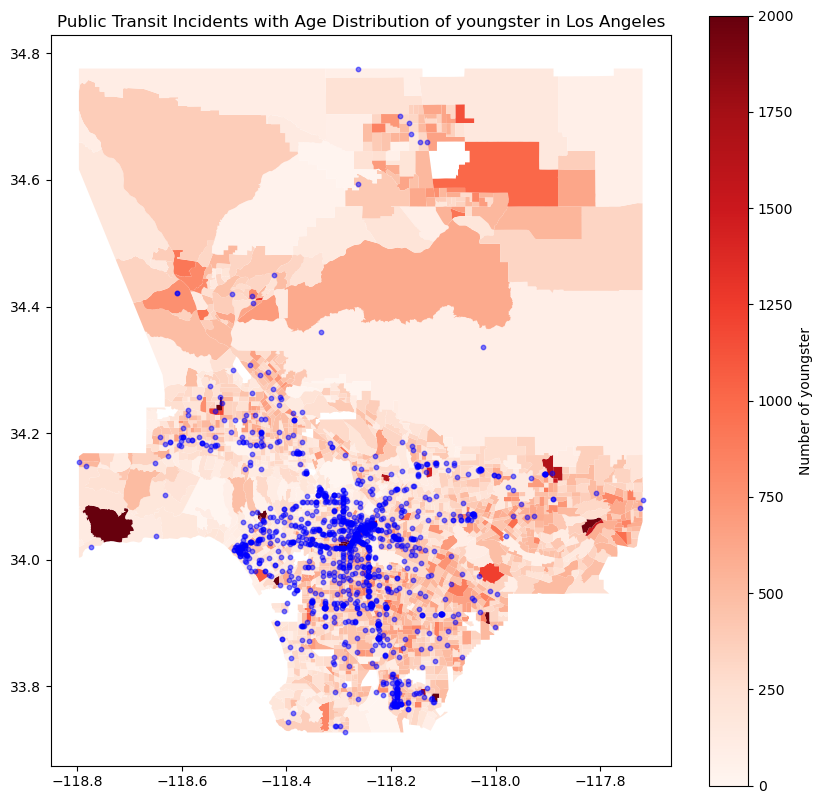

<Figure size 3000x3000 with 0 Axes>

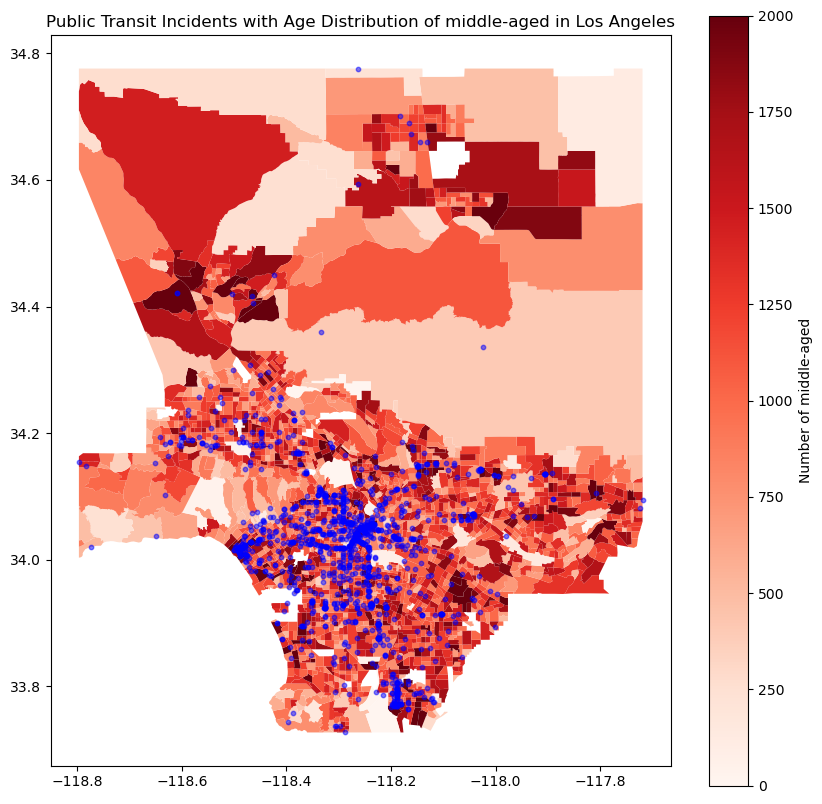

<Figure size 3000x3000 with 0 Axes>

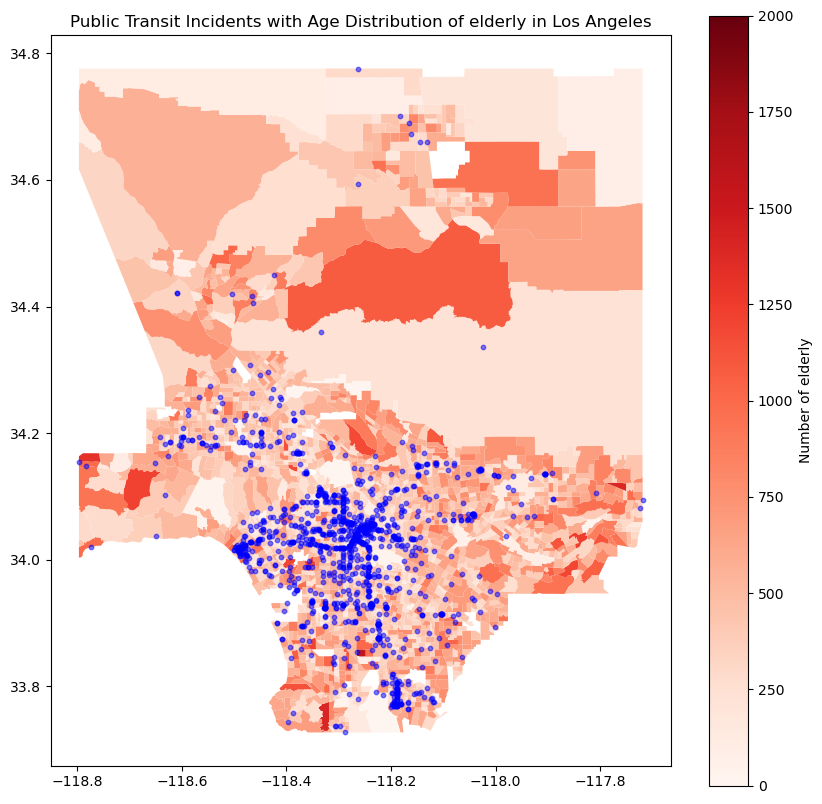

In [32]:
# First draw maps of the distribution of public transportation accidents.
for i in people_list:
    # Create a Graphic
    plt.figure(figsize=(30, 30))

    # The age distribution was first mapped and the axes were set to restrict to the boundaries of the accident data.
    ax = la_geo_data.clip(public_accidents_bounds).plot(
    column=i, 
    cmap='Reds', 
    legend=True,
    legend_kwds={'label': "Number of {}".format(i)},
    vmax=2000,
    figsize=(10, 10))
    
    # Add a title
    plt.title('Public Transit Incidents with Age Distribution of {} in Los Angeles'.format(i))
    
    # Plot accident points on the same axes.
    public_accidents_within_bounds.plot(
    ax=ax, 
    marker='o', 
    color='blue', 
    markersize=10, 
    alpha=0.5)


<Figure size 3000x3000 with 0 Axes>

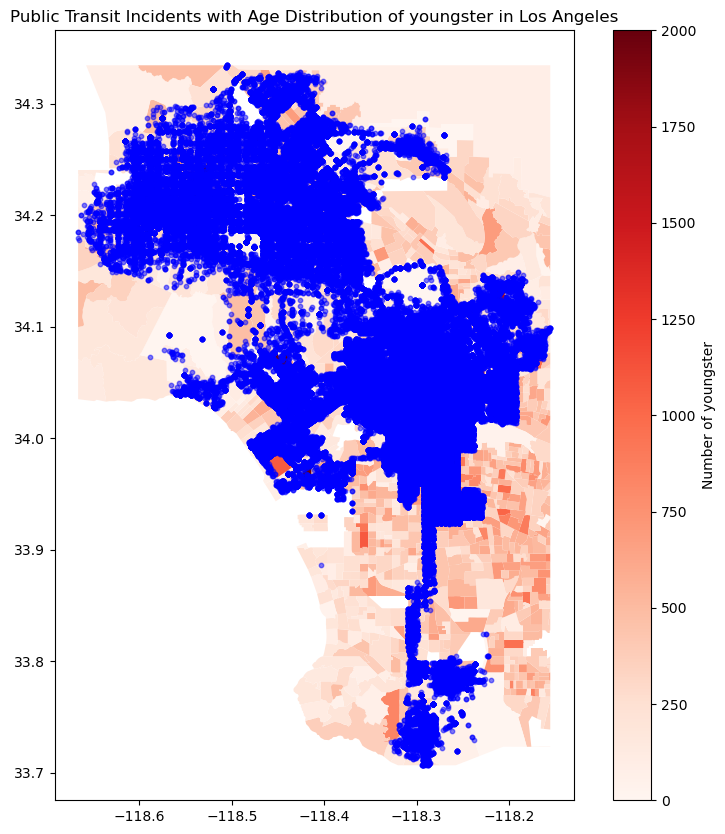

<Figure size 3000x3000 with 0 Axes>

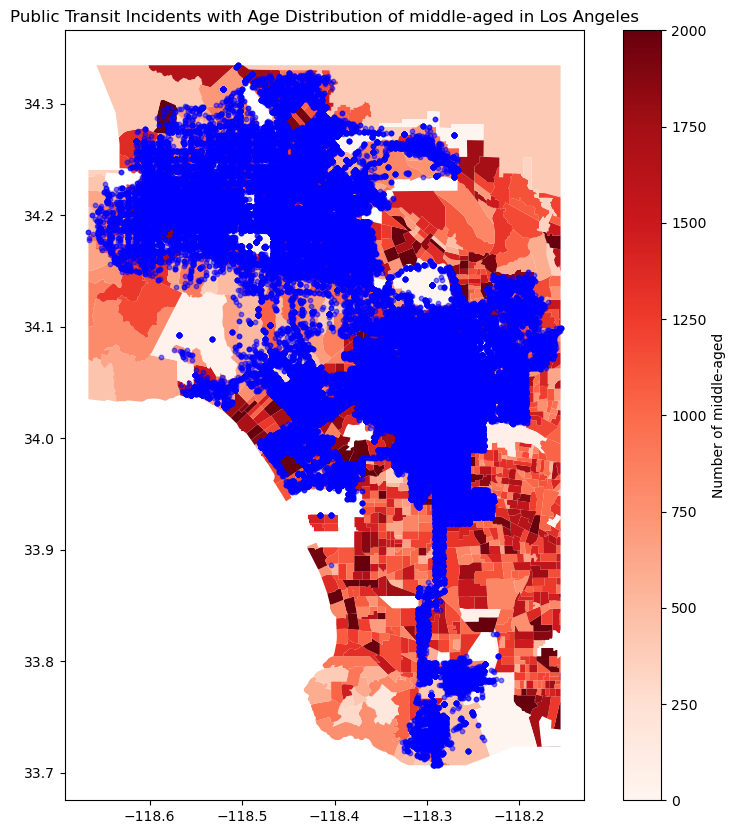

<Figure size 3000x3000 with 0 Axes>

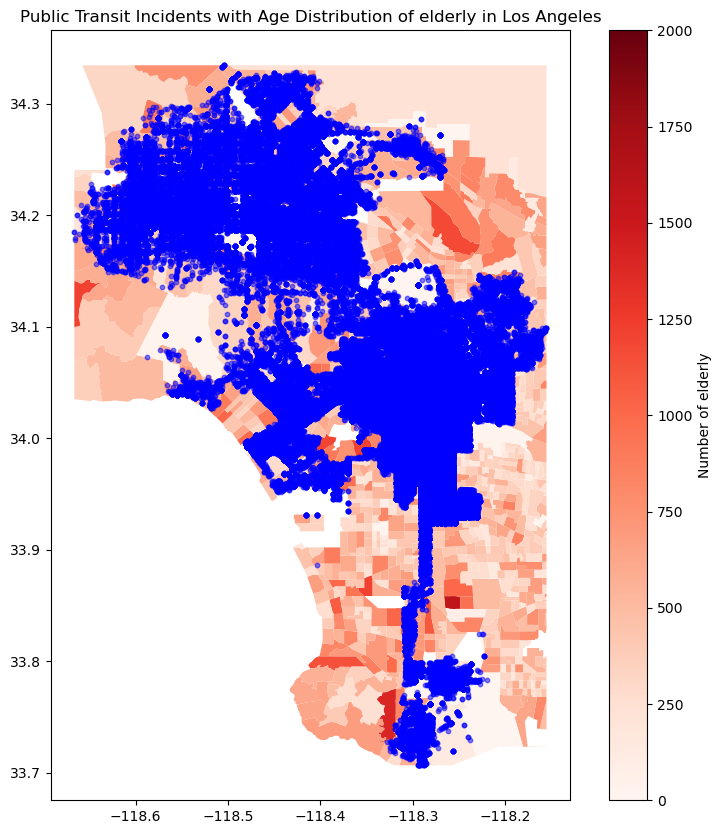

In [33]:
# Second draw maps of the distribution of private transportation accidents.
for i in people_list:
    # Create a Graphic
    plt.figure(figsize=(30, 30))

    # The age distribution was first mapped and the axes were set to restrict to the boundaries of the accident data.
    ax = la_geo_data.clip(private_accidents_bounds).plot(
    column=i, 
    cmap='Reds', 
    legend=True,
    legend_kwds={'label': "Number of {}".format(i)},
    vmax=2000,
    figsize=(10, 10))
    
    # Add a title
    plt.title('Public Transit Incidents with Age Distribution of {} in Los Angeles'.format(i))
    
    # Plot accident points on the same axes.
    private_accidents_within_bounds.plot(
    ax=ax, 
    marker='o', 
    color='blue', 
    markersize=10, 
    alpha=0.5)


# Define the function that calculates the kernel density with respect to the plot.
As you can see we have tried to put the data all in the same graph, but with that there is a serious problem, which is that I realized that we can't see the relationship between the two very clearly from the graph. So after doing some research I have found two ways to visualize the relationship between the two, they are: correlation analysis of the location of the two data, and kernel density plots. Correlation analysis is a quantitative method of analysis where we can calculate the correlation (numerical value) to accurately determine the relationship between accident distribution and age distribution, but it lacks some of the visual perspective of a map. So for this assignment, I would like to first try using a kernel density analysis map to see is by can visualize the relationship between the two, and make correlation analysis my next goal.

In [34]:
def calculate_and_plot_KD(accident_data, age_data, boundary, people_group, accident_type):
    
    # Extract the coordinates of the accident data points.
    x_a = accident_data.geometry.x
    y_a = accident_data.geometry.y

    # Calculate kernel density estimates.
    kde1 = gaussian_kde([x_a, y_a])
    xx1, yy1 = np.mgrid[boundary[0]:boundary[2]:100j, boundary[1]:boundary[3]:100j]
    positions1 = np.vstack([xx1.ravel(), yy1.ravel()])
    density1 = np.reshape(kde1(positions1).T, xx1.shape)
    
    # Extract the centroids coordinates of the age data points.
    centroids_x = age_data['centroid'].x
    centroids_y = age_data['centroid'].y

    # Calculate kernel density estimates.
    kde2 = gaussian_kde([centroids_x, centroids_y], weights=la_geo_data[people_group])
    xx2, yy2 = np.mgrid[boundary[0]:boundary[2]:100j, boundary[1]:boundary[3]:100j]
    positions2 = np.vstack([xx2.ravel(), yy2.ravel()])
    density2 = np.reshape(kde2(positions2).T, xx2.shape)

    # Start drawing.
    plt.figure(figsize=(10, 10))

    # Mapping the first kernel density.
    plt.imshow(np.rot90(density1), cmap='Reds', extent=[xx1.min(), xx1.max(), yy1.min(), yy1.max()], alpha=0.9)

    # Plot the second kernel density on the same axis.
    plt.imshow(np.rot90(density2), cmap='Blues', extent=[xx2.min(), xx2.max(), yy2.min(), yy2.max()], alpha=0.7)

    plt.colorbar()
    plt.title('Overlay of Density Plot of {} and Age({}) Distribution'.format(accident_type, people_group))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # plt.savefig('Public_KDE_and_elderly.png', dpi=300)  # (optional) save the graphic to a file, you can adjust the dpi parameter to change the resolution

    plt.show()

# Define some parameters to use the function

In [35]:
accident_type = ['Public Transit Incidents', 'Private Transit Incidents']

# Calculate the midpoint.
la_geo_data['centroid'] = la_geo_data.centroid

/tmp/ipykernel_230/3328354267.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  la_geo_data['centroid'] = la_geo_data.centroid


# Using the Function

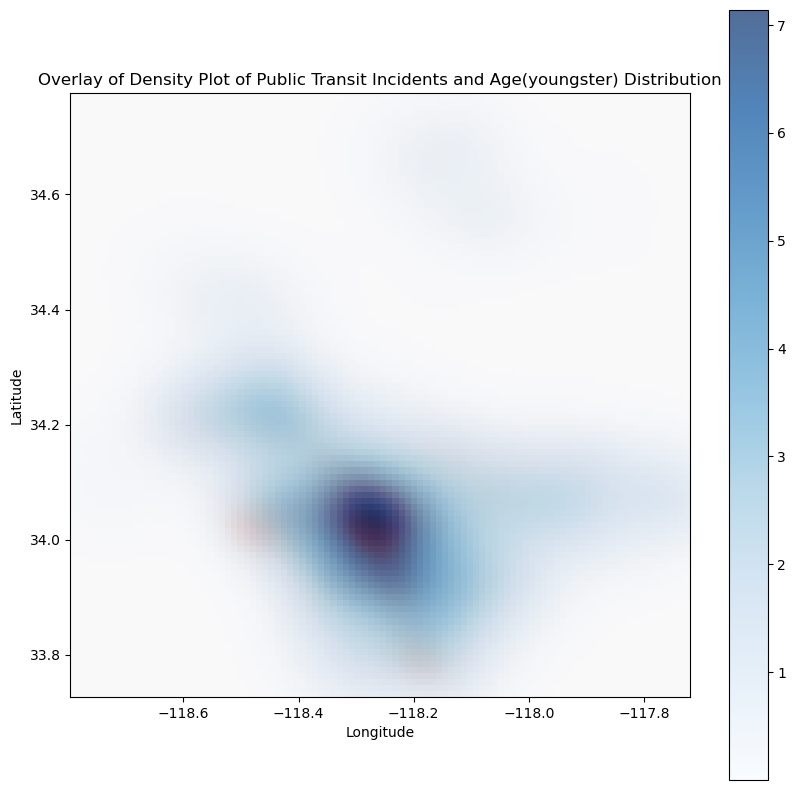

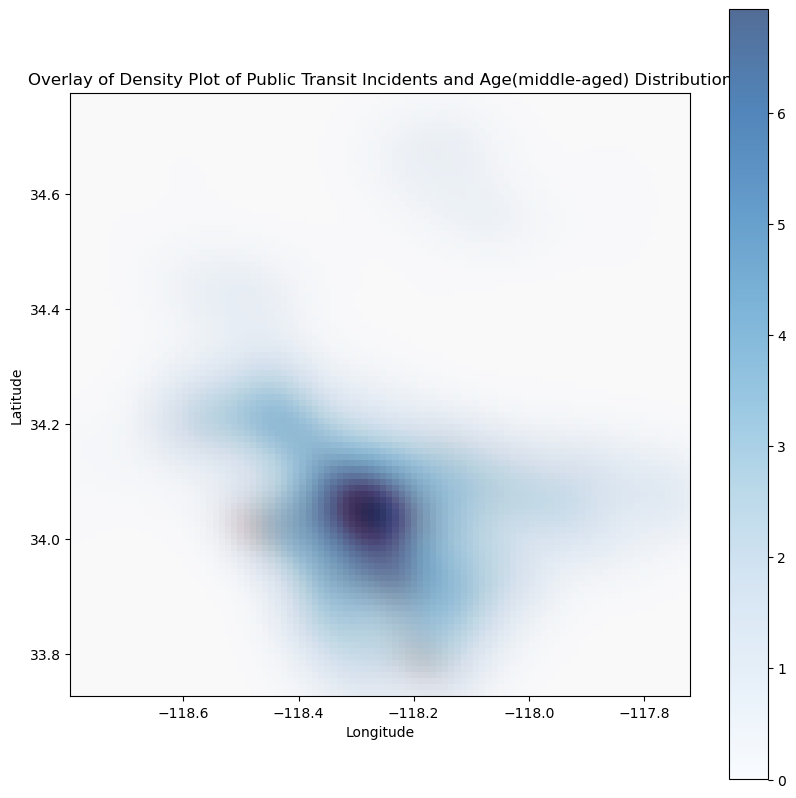

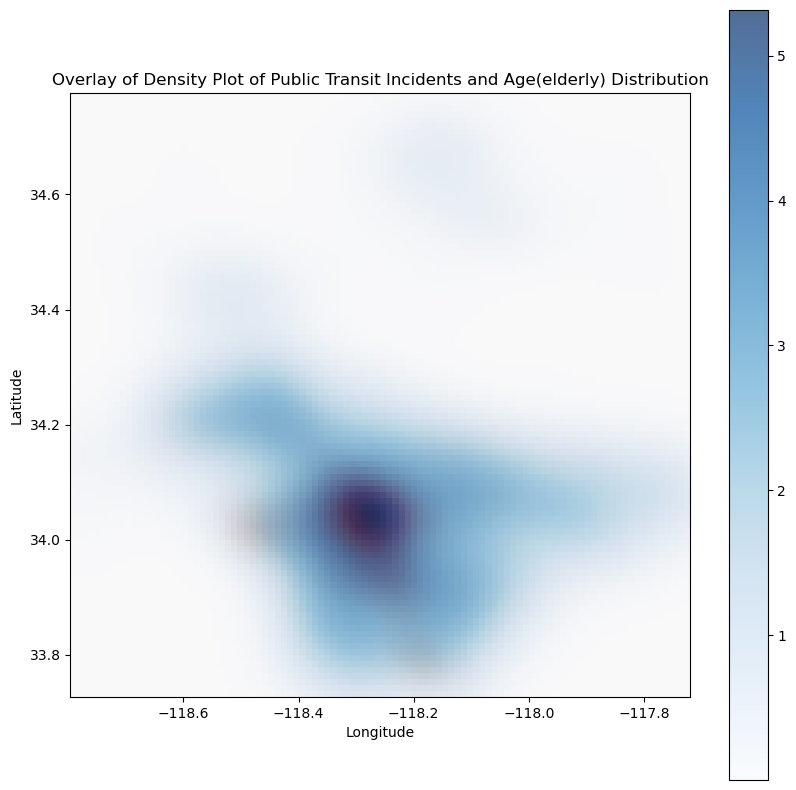

In [36]:
for i in people_list:
    calculate_and_plot_KD(public_accidents_within_bounds, la_geo_data, public_accidents_bounds, i, accident_type[0])

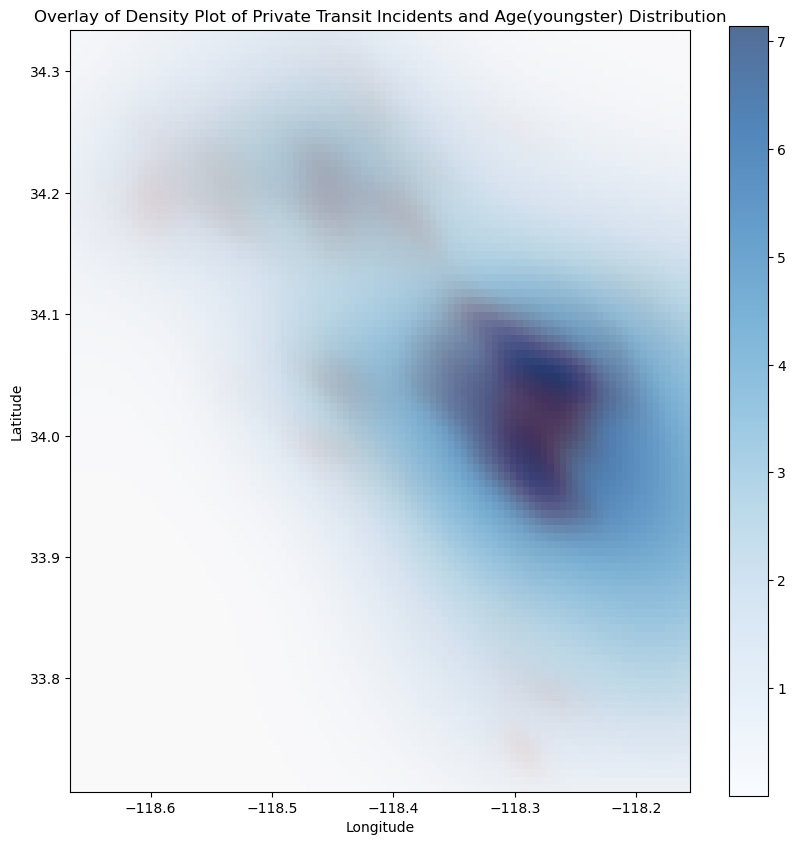

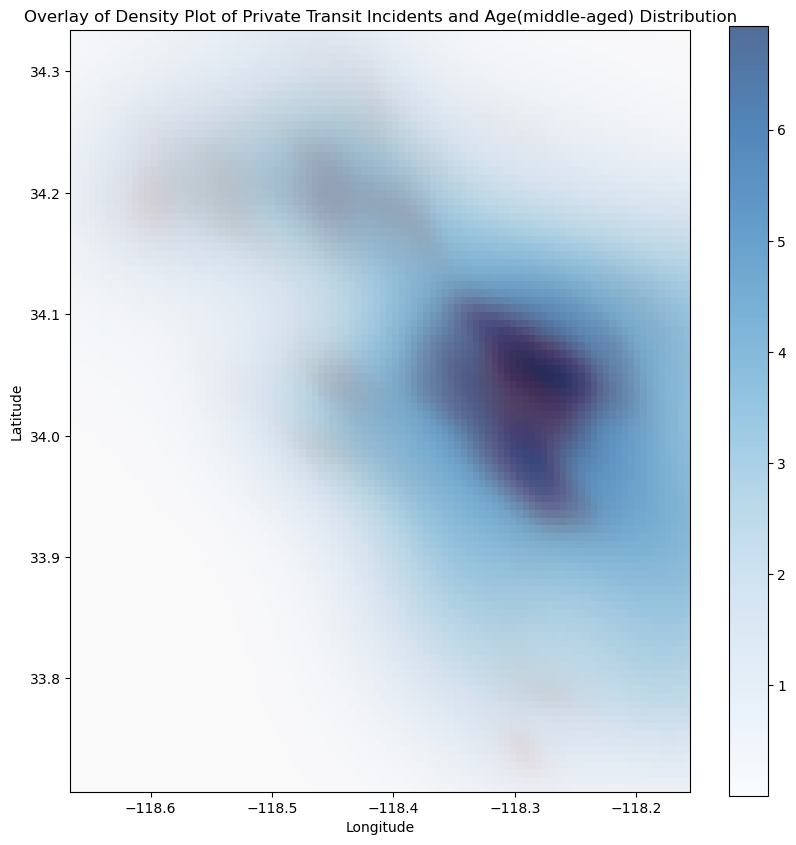

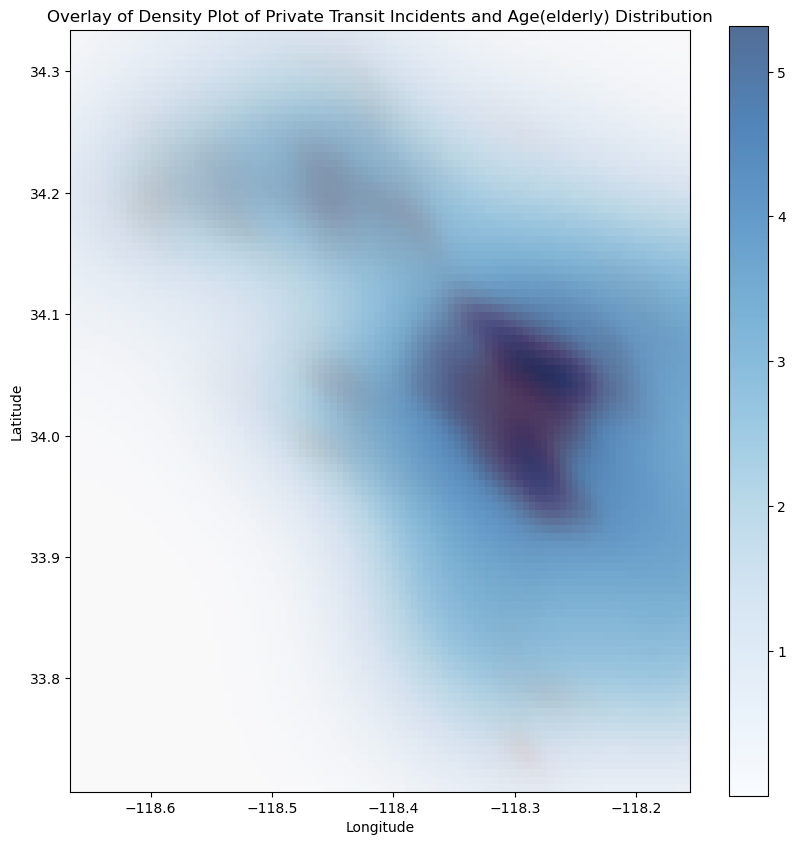

In [39]:
for i in people_list:
    calculate_and_plot_KD(private_accidents_within_bounds, la_geo_data, private_accidents_bounds, i, accident_type[1])

I am yaofa Gong(306299097), In this group assignment, I was primarily responsible for analyzing the relationship between accident distribution and age distribution.